In [2]:
import numpy as np
import gymnasium as gym
from dataclasses import dataclass
import typing as tt
import matplotlib.pyplot as plt

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

In [4]:
HIDDEN_SIZE = 128
BATCH_SIZE = 16
PERCENTILE = 70

In [5]:
class Net(nn.Module):
    def __init__(self, obs_size: int, hidden_size: int, n_actions: int):
        super(Net, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, n_actions)
        )

    def forward(self, x: torch.Tensor):
        return self.net(x)

In [6]:
@dataclass
class EpisodeStep:
    observation: np.ndarray
    action: int

@dataclass
class Episode:
    reward: float
    steps: tt.List[EpisodeStep]

In [7]:
def iterate_batches(env: gym.Env, net: Net, batch_size: int) -> tt.Generator[tt.List[Episode], None, None]:
    batch = []
    episode_reward = 0.0
    episode_steps = []
    obs, _ = env.reset()
    sm = nn.Softmax(dim=1)
    while True:
        obs_v = torch.tensor(obs, dtype=torch.float32)
        act_probs_v = sm(net(obs_v.unsqueeze(0)))
        act_probs = act_probs_v.data.numpy()[0]
        action = np.random.choice(len(act_probs), p=act_probs)
        next_obs, reward, is_done, is_trunc, _ = env.step(action)
        episode_reward += float(reward)
        step = EpisodeStep(observation=obs, action=action)
        episode_steps.append(step)
        if is_done or is_trunc:
            e = Episode(reward=episode_reward, steps=episode_steps)
            batch.append(e)
            episode_reward = 0.0
            episode_steps = []
            next_obs, _ = env.reset()
            if len(batch) == batch_size:
                yield batch
                batch = []
        obs = next_obs

In [8]:
def filter_batch(batch: tt.List[Episode], percentile: float) -> \
        tt.Tuple[torch.FloatTensor, torch.LongTensor, float, float]:
    rewards = list(map(lambda s: s.reward, batch))
    reward_bound = float(np.percentile(rewards, percentile))
    reward_mean = float(np.mean(rewards))

    train_obs: tt.List[np.ndarray] = []
    train_act: tt.List[int] = []
    for episode in batch:
        if episode.reward < reward_bound:
            continue
        train_obs.extend(map(lambda step: step.observation, episode.steps))
        train_act.extend(map(lambda step: step.action, episode.steps))

    train_obs_v = torch.FloatTensor(np.vstack(train_obs))
    train_act_v = torch.LongTensor(train_act)
    return train_obs_v, train_act_v, reward_bound, reward_mean

In [9]:
env = gym.make("CartPole-v1")
assert env.observation_space.shape is not None
obs_size = env.observation_space.shape[0]
assert isinstance(env.action_space, gym.spaces.Discrete)
n_actions = int(env.action_space.n)

net = Net(obs_size, HIDDEN_SIZE, n_actions)
print(net)
objective = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=net.parameters(), lr=0.01)

losses = []
reward_means = []
reward_bounds = []

for iter_no, batch in enumerate(iterate_batches(env, net, BATCH_SIZE)):
    obs_v, acts_v, reward_b, reward_m = filter_batch(batch, PERCENTILE)
    optimizer.zero_grad()
    action_scores_v = net(obs_v)
    loss_v = objective(action_scores_v, acts_v)
    loss_v.backward()
    optimizer.step()
    print("%d: loss=%.3f, reward_mean=%.1f, rw_bound=%.1f" % (
        iter_no, loss_v.item(), reward_m, reward_b))
    
    losses.append(loss_v.item())
    reward_means.append(reward_m)
    reward_bounds.append(reward_b)
    
    if reward_m > 475:
        print("Solved!")
        break

Net(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=2, bias=True)
  )
)
0: loss=0.697, reward_mean=21.5, rw_bound=28.0
1: loss=0.673, reward_mean=27.4, rw_bound=31.0
2: loss=0.669, reward_mean=29.9, rw_bound=36.0
3: loss=0.644, reward_mean=33.7, rw_bound=40.5
4: loss=0.639, reward_mean=44.1, rw_bound=51.0
5: loss=0.634, reward_mean=46.8, rw_bound=57.0
6: loss=0.618, reward_mean=55.4, rw_bound=64.5
7: loss=0.610, reward_mean=49.2, rw_bound=53.0
8: loss=0.596, reward_mean=58.0, rw_bound=66.0
9: loss=0.584, reward_mean=59.8, rw_bound=70.0
10: loss=0.619, reward_mean=57.4, rw_bound=60.0
11: loss=0.565, reward_mean=56.7, rw_bound=60.5
12: loss=0.562, reward_mean=42.7, rw_bound=44.0
13: loss=0.575, reward_mean=66.3, rw_bound=68.0
14: loss=0.552, reward_mean=51.8, rw_bound=63.5
15: loss=0.574, reward_mean=57.5, rw_bound=65.0
16: loss=0.549, reward_mean=66.5, rw_bound=78.5
17: loss=0.543, reward_mea

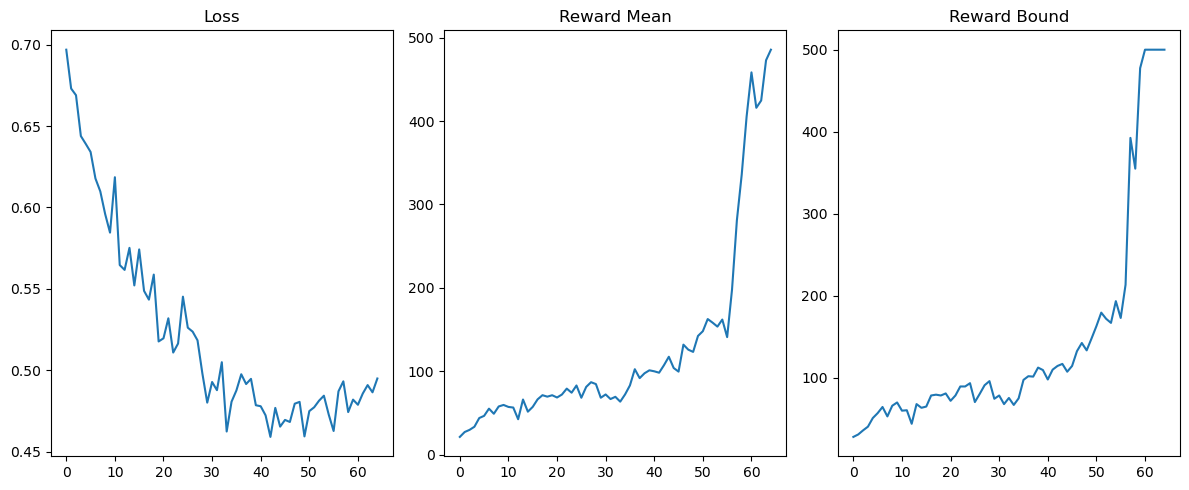

In [10]:
# Plotting the results
plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.plot(losses)
plt.title('Loss')

plt.subplot(1, 3, 2)
plt.plot(reward_means)
plt.title('Reward Mean')

plt.subplot(1, 3, 3)
plt.plot(reward_bounds)
plt.title('Reward Bound')

plt.tight_layout()
plt.show()